In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import kagglehub
import shutil
import os
import torch.optim.lr_scheduler as lrSched
from sklearn.metrics import confusion_matrix
import random

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import and move the dataset

In [2]:
path = kagglehub.dataset_download("gpreda/chinese-mnist")

print("Path to dataset files:", path)


for file_name in os.listdir(path):
    full_file_name = os.path.join(path, file_name)
    if os.path.isfile(full_file_name):
        shutil.move(full_file_name, './')



Path to dataset files: C:\Users\mathi\.cache\kagglehub\datasets\gpreda\chinese-mnist\versions\7


In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),  # Ensure the image is in 1 channel
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Use single values for grayscale
])


### Splitting the data in a train dataset (80%) and a test dataset (20%)

In [4]:
dataset = pd.read_csv('chinese_mnist.csv')


characters = dataset['character'].unique().tolist()
print(characters)
print(len(characters))

['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
15


In [5]:
IMAGE_PATH = path + "/data/data/"
print("dataframe (index file) rows:", dataset.shape[0]) 
print("image files :", len(os.listdir(IMAGE_PATH)))
filenames = os.listdir(IMAGE_PATH)
filenames[0:5]

dataframe (index file) rows: 15000
image files : 15000


['input_100_10_1.jpg',
 'input_100_10_10.jpg',
 'input_100_10_11.jpg',
 'input_100_10_12.jpg',
 'input_100_10_13.jpg']

In [6]:

# Select 5 random filenames
random_filenames = random.sample(filenames, 5)

# Print the selected filenames
print("Randomly selected filenames:", random_filenames)

# Download (copy) the 5 random images to a new folder (for example 'random_images')
download_folder = "random_images"
os.makedirs(download_folder, exist_ok=True)

# Copy the 5 random images to the download folder
for filename in random_filenames:
    src = os.path.join(IMAGE_PATH, filename)
    dest = os.path.join(download_folder, filename)
    shutil.copy(src, dest)

Randomly selected filenames: ['input_39_2_10.jpg', 'input_67_6_3.jpg', 'input_1_9_9.jpg', 'input_48_8_8.jpg', 'input_70_4_1.jpg']


In [7]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np

class ChineseMNISTdataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir, transform=None):
        self.df = annotations_dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        imgPath = os.path.join(self.img_dir, self.df['file'][idx]) 
        img = Image.open(imgPath)

        # Ensure the image is in grayscale
        img = img.convert('L')  # Convert to grayscale if it's not already
        
        # Apply transformations if they are provided
        if self.transform:
            img = self.transform(img)
        
        # Convert image to tensor format
        imgAsT = torch.from_numpy(np.array(img)).float()

        # If the image is 2D (grayscale), add the channel dimension
        if imgAsT.ndimension() == 2:
            imgAsT = imgAsT.unsqueeze(0)  # Add channel dimension (shape becomes [1, 64, 64])

        # Normalize the image
        imgAsT = imgAsT / 255.0  # Normalize to [0, 1] if necessary (optional based on your transform)

        # Retrieve the label (code)
        label = self.df['code'][idx] - 1  # Subtract 1 to start the labels from 0

        return imgAsT, label


In [8]:
dataset['file'] = dataset[['suite_id','sample_id','code']].apply(lambda x: 'input_' + 
                 x['suite_id'].astype(str) +'_'+x['sample_id'].astype(str)+'_'+x['code'].astype(str)+'.jpg', axis=1)
dataset.head(5)

,suite_id,sample_id,code,value,character,file
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


In [9]:
imgPath =  os.path.join(IMAGE_PATH, dataset['file'][4000]) 
im = Image.open(imgPath)
print(im.mode)
im.size



L


(64, 64)

In [10]:
chineseNumbers = ChineseMNISTdataset(dataset, IMAGE_PATH)  # init
chineseNumbers.__len__() # dataset length




15000

In [11]:
BATCH_SIZE = 64


train_size = int(0.8 * len(chineseNumbers))  # 80% for training
test_size = len(chineseNumbers) - train_size  # Remaining 20% for testing
train_data, test_data = random_split(chineseNumbers, [train_size, test_size])

len(train_data), len(test_data)


(12000, 3000)

In [12]:

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=True)

len(train_loader), len(test_loader)


(188, 47)

In [13]:
# Checking the size of the first batch in the train_loader
for batch_idx, (X, y) in enumerate(train_loader):
    print(f"Batch {batch_idx} - X size: {X.size()}, y size: {y.size()}")
    break  # Only check the first batch


Batch 0 - X size: torch.Size([64, 1, 64, 64]), y size: torch.Size([64])


torch.Size([1, 64, 64])
9


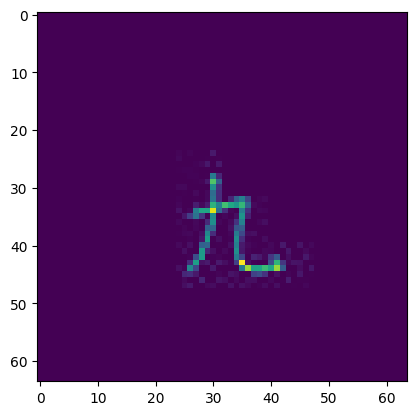

In [14]:
img, label = chineseNumbers.__getitem__(42)
print(img.shape)
print(label)


img = img.squeeze(0).numpy()
plt.imshow(img)



In [15]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())  # Returns current device index
print(torch.cuda.device_count())    # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


True
0
1
NVIDIA GeForce GTX 1060 3GB


In [16]:
class_names = ['0'  , '1'  , '2'  , '3'  , '4'  , '5'  , '6'  , '7'  , '8'  , '9'  , '10' , '100', '1000', '10000', '100000000']

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Output: (64, 64, 64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: (128, 64, 64)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Output: (256, 64, 64)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Output: (512, 64, 64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces each dimension by half

        # Dropout layers
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)  # Adjusted for 4x4 feature map size
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 15)  # Output layer with 15 classes

        # Initialize weights (e.g., Xavier initialization for conv and linear layers)
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize convolution layers and fully connected layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Conv4 -> BatchNorm -> ReLU -> Pool
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.dropout(F.relu(self.fc1(x)))  # Fully connected layer 1 with dropout
        x = self.dropout(F.relu(self.fc2(x)))  # Fully connected layer 2 with dropout
        x = self.fc3(x)  # Fully connected layer 3 (output)
        return x


In [18]:
net = NeuralNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = lrSched.StepLR(optimizer, step_size = 30, gamma = 0.1)


In [ ]:
lossHistory = []
NUM_EPOCHS = 30

for e in range(NUM_EPOCHS):
    print(f"Epoch: {e+1}/{NUM_EPOCHS}")

    epochLoss = 0
    correct = 0
    totalExamples = 0
    trainLosses = []

    # Check to ensure train_loader is working properly
    if len(train_loader) == 0:
        print("Error: train_loader is empty!")
        break

    for batchIdx, (X, y) in enumerate(train_loader):
        # Ensure that batches are being retrieved and have the correct size
        if X.size(0) != BATCH_SIZE and batchIdx != len(train_loader) - 1:
            print(f"Warning: Batch size mismatch at batch {batchIdx}, expected {BATCH_SIZE} but got {X.size(0)}")
        
        # Move data to the device
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        outputs = net(X)
        batchLoss = loss_function(outputs, y)  # Calculate the loss
        trainLosses.append(batchLoss.detach())  # Detach the loss to remove gradients

        # Backward pass
        batchLoss.backward()

        # Update model parameters
        optimizer.step()
        optimizer.zero_grad()

        # Track the epoch loss
        epochLoss += batchLoss.item()

        # Print status every 50 batches
        if batchIdx % 50 == 0:
            totImages = batchIdx * BATCH_SIZE + len(X)
            print(f"\tIteration: {batchIdx}\t Current batch Loss: {batchLoss:.3f} | images: {totImages} | epoch loss/n: {epochLoss/len(train_loader):.3f}")

        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        compare = y == preds
        correct += torch.sum(compare)
        totalExamples += len(compare)

    # Step the learning rate scheduler
    scheduler.step()

    # Print epoch summary
    accuracy = (correct / totalExamples).item()
    print(f"  Train epoch loss: {epochLoss:.2f} | mean: {torch.stack(trainLosses).mean().item():.2f} | accuracy: {accuracy:.2f} | lr: {scheduler.get_last_lr()}")
    lossHistory.append(torch.stack(trainLosses).mean().item())

    # Plot the first image with prediction and actual value
    first_img = X[0].cpu().squeeze(0).numpy()
    actual_label = y[0].cpu().item()
    predicted_label = preds[0].cpu().item()
    
    plt.imshow(first_img, cmap='gray')
    plt.title(f'Actual: {class_names[actual_label]}, Predicted: {class_names[predicted_label]}')
    plt.axis('off')
    plt.show()

print("Done!")


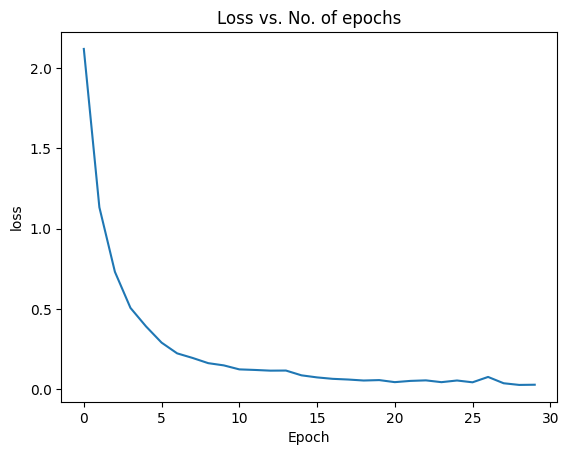

In [20]:
plt.plot(lossHistory)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')
plt.show()

In [21]:
def computeAccuracy(model, data):
    model = model.eval()
    correct = 0.0
    totalExamples = 0
    totalLabels = np.array([])
    totalPred = np.array([])

    for idx, (features, labels) in enumerate(data):
        with torch.no_grad():
            features = features.to(device)
            labels = labels.to(device)
            logits = model(features) # run the model to get the predictions

        predictions = torch.argmax(logits, dim=1)
        compare = labels == predictions  # compare predictions with true label

        correct += torch.sum(compare)
        totalExamples += len(compare)

        totalLabels = np.concatenate((totalLabels, labels.cpu().numpy()))
        totalPred = np.concatenate((totalPred, predictions.cpu().numpy()))

    cm = confusion_matrix(totalLabels, totalPred)  # assemble the confusion matrix and print it
    print(f'Confusion matrix: \n{cm}')

    return (correct / totalExamples).item()  # return the accuracy

In [35]:
acc = computeAccuracy(net, test_loader)
print(f"\nAccuracy: {acc*100} %")


Confusion matrix: 
[[217   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 183   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1 191   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2 183   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0 204   0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   1   0 203   0   1   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0 207   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0 180   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   1   0 199   0   0   1   0   0   2]
 [  0   0   0   0   0   0   0   0   0 197   0   0   0   4   3]
 [  0   0   0   0   0   0   0   0   0   0 207   0   2   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0 208   0   2   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0 181   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0 193   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 218]]

Accuracy: 99.03333187103271 %


In [23]:
torch.save(net.state_dict(), 'trained_net.pth')

In [24]:
net = NeuralNet().to(device)
net.load_state_dict(torch.load('trained_net.pth'))

<All keys matched successfully>

In [42]:
import os
from PIL import Image
import torch
from torchvision import transforms


download_folder = "random_images"
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
net = NeuralNet().to(device)
net.load_state_dict(torch.load('trained_net.pth'))
net.eval()  # Set the model to evaluation mode

# Define the preprocessing pipeline
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale if the model expects it
    transforms.Resize((64, 64)),  # Resize to match the input size (adjust if needed)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to match the training data
])

# Iterate over all files in the folder
for filename in os.listdir(download_folder):
    file_path = os.path.join(download_folder, filename)
    try:
        # Open the image
        img = Image.open(file_path)

        # Preprocess the image
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Get prediction from the model
        with torch.no_grad():
            output = net(img_tensor)
            predicted_class = output.argmax(dim=1).item()

        # Display the result
        print(f"Image: {filename}, Predicted Chinese Number: {predicted_class}")

    except Exception as e:
        print(f"Error processing file {filename}: {e}")


Image: 1000.jpg, Predicted Chinese Number: 0
Image: 10000.jpg, Predicted Chinese Number: 0
Image: 3.jpg, Predicted Chinese Number: 0
Image: 5.jpg, Predicted Chinese Number: 4
Image: 8.jpg, Predicted Chinese Number: 4
Image: input_17_5_14.jpg, Predicted Chinese Number: 6
Image: input_21_6_13.jpg, Predicted Chinese Number: 6
Image: input_25_8_14.jpg, Predicted Chinese Number: 6
Image: input_39_2_10.jpg, Predicted Chinese Number: 6
Image: input_40_2_7.jpg, Predicted Chinese Number: 6


In [ ]:
# List of image paths
image_paths = [os.path.join(download_folder, filename) for filename in os.listdir(download_folder)]
from PIL import Image, ImageOps, ImageFilter

def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.filter(ImageFilter.MedianFilter(size=3))  # Noise reduction
    img = ImageOps.autocontrast(img)  # Improve contrast
    img = img.resize((64, 64))  # Resize to match training data
    return img


# Set the model to evaluation mode
net.eval()

# Process and predict each image
with torch.no_grad():
    for image_path in image_paths:
        # Preprocess the raw image
        processed_image = preprocess_image(image_path)
        
        # Apply the transformation pipeline (convert to tensor, normalize, etc.)
        transformed_image = transform(processed_image).unsqueeze(0).to(device)  # Add batch dimension

        # Get the output of the model
        output = net(transformed_image)

        # Get the predicted class
        _, predicted = torch.max(output, 1)

        # Plot the original image and the predicted class
        plt.imshow(processed_image, cmap='gray')  # Use the processed image for visualization
        plt.title(f'Predicted: {class_names[predicted.item()]}')
        plt.axis('off')  # Hide the axes
        plt.show()